# Import Dependencies

In [2]:
%pip install cdlib scikit-learn pandas plotly hvplot community python-louvain dynetx seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import networkx as nx
import dynetx as dn

from cdlib import algorithms, evaluation
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_rand_score


from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.spatial import distance

from networkx.algorithms import approximation
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.centrality import closeness_centrality

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from sklearn.metrics import pair_confusion_matrix
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import colorsys
import random

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'graph_tool', 'leidenalg', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


# Level 1 Network Formation

We experiment with varying levels of delta, from (0.15, 0.5, 0.85).

In [13]:
# Load the dataset
file_path = "../dataset/level_1/level_1.txt"
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns
genes = df["Gene"]
level_1_classes = df["Level_1"]
expression_data = df.iloc[:, 2:].values  # Extract time-series expression data

# Compute Pearson correlation matrix
correlation_matrix = np.corrcoef(expression_data)

# Threshold for value-based graph construction
delta_values = [0.15, 0.5, 0.85]

# Initialize array to store results for each delta value
results = []

for delta in delta_values:
    threshold = delta
    adjacency_matrix = (correlation_matrix >= threshold ).astype(int)

    # Create a graph
    G = nx.Graph()

    # Add nodes with Level 1 classification as attributes
    for idx, gene in enumerate(genes):
        G.add_node(gene, level_1=level_1_classes[idx])

    # Add edges based on Pearson correlation threshold
    edges = []
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if adjacency_matrix[i, j] == 1:
                pearson_coefficient = correlation_matrix[i, j]
                G.add_edge(genes[i], genes[j], weight=pearson_coefficient)

    # Remove singletons
    singletons = list(nx.isolates(G))
    G.remove_nodes_from(singletons)

    # Compute additional graph properties
    avg_degree = sum(dict(G.degree()).values()) / len(G.nodes())  # Average degree
    density = nx.density(G)  # Graph density
    avg_clustering = nx.average_clustering(G)  # Average clustering coefficient
    largest_cc = max(nx.connected_components(G), key=len)  # Largest connected component
    largest_cc_size = len(largest_cc)  # Size of the largest component
    diameter = nx.diameter(G.subgraph(largest_cc)) if nx.is_connected(G) else None  # Diameter

    # Store results for the current delta, including the graph
    results.append({
        "Delta": delta,
        "Graph": G,  # Store the graph object
        "Number of Nodes": len(G.nodes()),
        "Number of Edges": G.number_of_edges(),
        "Transitivity": nx.transitivity(G) if len(G.nodes()) > 0 else 0,
        "Singletons Removed": len(singletons),
        "Average Degree": avg_degree,
        "Density": density,
        "Average Clustering Coefficient": avg_clustering,
        "Largest Component Size": largest_cc_size,
        "Diameter (if connected)": diameter
    })

# Convert results to a DataFrame for visualization (excluding the graph object)
graph_properties = pd.DataFrame([{k: v for k, v in result.items() if k != "Graph"} for result in results])

output_dir = "../results/level_1"
if not os.path.exists(output_dir):
	os.makedirs(output_dir)

# Save graph properties to a CSV file
graph_properties.to_csv(f"{output_dir}/graph_properties.csv", index=False)
graph_properties

,Delta,Number of Nodes,Number of Edges,Transitivity,Singletons Removed,Average Degree,Density,Average Clustering Coefficient,Largest Component Size,Diameter (if connected)
0,0.15,384,31622,0.763279,0,164.697917,0.430021,0.750456,384,3.0
1,0.50,384,18217,0.789861,0,94.880208,0.247729,0.739437,384,5.0
2,0.85,316,2925,0.614688,68,18.512658,0.058770,0.544421,310,NaN


# Level 1 Network Visualization

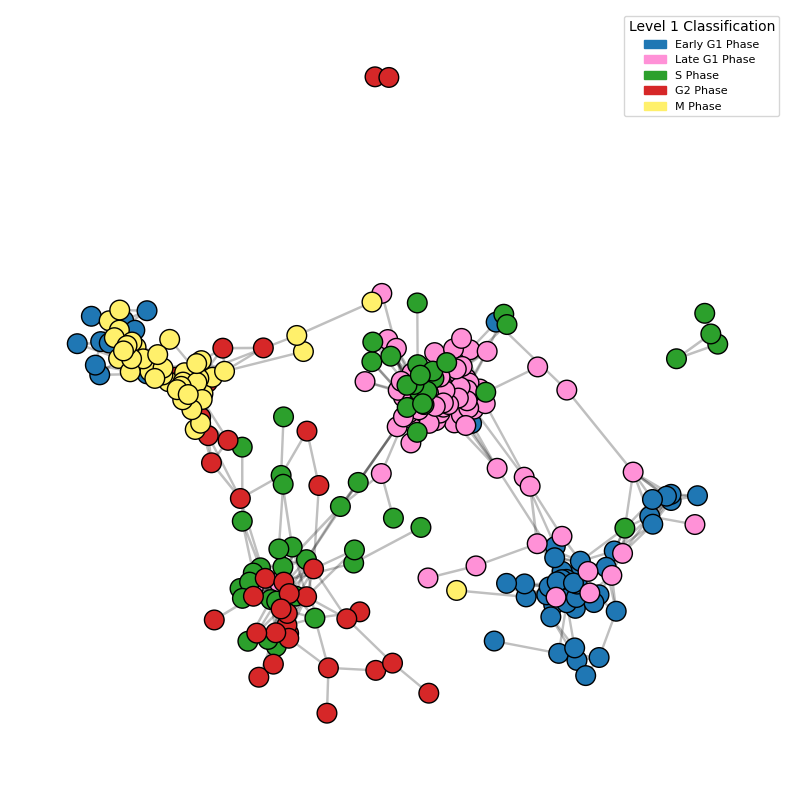

In [15]:
TABLEAU_COLORS = {
    'tab:blue': '#1f77b4',
    'tab:pink': '#ff91d7',
    'tab:green': '#2ca02c',
    'tab:red': '#d62728',
    'tab:yellow': '#fff06b',
}
# Define unique colors for each Level 1 classification
unique_classes = level_1_classes.unique()
color_map = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]] for i, cls in enumerate(unique_classes)}

# Use the graph with delta = 0.85
G = results[2]["Graph"]  # Choose the graph with delta = 0.85

# Assign colors to nodes based on Level 1 classification
node_colors = [color_map[G.nodes[n]["level_1"]] for n in G.nodes()]

# Edge weights for visualization (stronger edges appear tighter)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Generate graph layout
plt.figure(figsize=(10, 10))
cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
legend_handles = [Patch(color=color, label=f'{cell_cycle_phases[cls-1]}') for cls, color in color_map.items()]
plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Classification")
pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)  # Spring layout based on weights

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

# Draw edges with thickness based on weight
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

# Show plot
# plt.title(f"Cho Gene Co-Expression Network (Value-Based, δ = {delta})")
plt.axis("off")
plt.savefig("../results/level_1/visualization/level1_gcn.png", dpi=300)
plt.show()

# Community Detection Auxiliary Functions

These are the functions used during the Community Detection of our constructed network.

In [5]:
def visualize_community(G, communities, title, output_dir, file_name, save_file=False):
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Recalculate layout to ensure all nodes are included

    cmap = plt.get_cmap('viridis', len(communities))

    for i, community in enumerate(communities):
        if community:  # Check if community is not empty
            # Filter out nodes not present in the graph
            valid_nodes = [node for node in community if node in G]
            nx.draw_networkx_nodes(G, pos, nodelist=valid_nodes, node_color=[cmap(i)], alpha=0.8)

    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    legend_handles = [mpatches.Patch(color=cmap(i), label=f'Community {i + 1}') for i in range(len(communities))]
    plt.legend(handles=legend_handles, loc='upper left', title="Communities")
    plt.title(f"{title} Algorithm Communities")
    plt.axis('off')
    plt.tight_layout()
    if save_file:
        plt.savefig(f"{output_dir}/{file_name}_{title}.png", bbox_inches="tight")
    plt.show()

In [20]:
def visualize_disconnected_communities(G, communities, color_map, title="Paris Algorithm Communities"):
    """
    Visualizes detected communities as separate disconnected subgraphs while keeping Level 1 colors.

    Parameters:
    - G: NetworkX graph
    - communities: CDLib NodeClustering object (Paris, Infomap, Louvain, etc.)
    - color_map: Dictionary mapping Level 1 categories to colors
    - title: Title for the plot
    """

    # Define layout positioning for separate communities
    num_communities = len(communities.communities)
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate separate layouts for each community
    layouts = []
    for i in range(num_communities):
        layouts.append(nx.spring_layout(G.subgraph(communities.communities[i]), seed=42))

    # Normalize layout positions to avoid overlap
    spacing = 3
    for i, layout in enumerate(layouts):
        for node in layout:
            layout[node] += [i * spacing, 0]  # Shift positions to separate communities

    # Draw each community separately
    for i, community in enumerate(communities.communities):
        subG = G.subgraph(community)
        pos = layouts[i]

        # Assign Level 1 colors
        node_colors = [color_map[G.nodes[n]["level_1"]] for n in subG.nodes()]

        # Draw nodes
        nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

        # Draw edges
        nx.draw_networkx_edges(subG, pos, alpha=0.3, edge_color="black")

    # Create a legend for Level 1 classification
    cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
    legend_handles = [Patch(color=color, label=f'{cell_cycle_phases[cls-1]}') for cls, color in color_map.items()]
    plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Classification")

    # Display
    plt.title(title)
    plt.axis("off")
    plt.show()


In [17]:
import itertools

def modified_rand_score(labels_true, labels_pred, nodes_true_list, nodes_pred_list):
    """
    Compute the Modified Rand Index (MRI), an extension of the Rand Index
    that accounts for missing elements between partitions.

    Parameters
    ----------
    labels_true : list
        True labels corresponding to the nodes.
    labels_pred : list
        Predicted labels corresponding to the nodes.
    nodes_true_list : list
        An ordered list of nodes corresponding to labels_true.
    nodes_pred_list : list
        An ordered list of nodes corresponding to labels_pred.

    Returns
    -------
    mri : float
        The Modified Rand Index score.
    """

    n = len(labels_true)
    total_pairs = n * (n - 1) // 2  # All possible unique node pairs
    n_00, n_11, n_xx = 0, 0, 0  # Initialize counts

    # Convert lists to sets for fast lookup
    nodes_true_set = set(nodes_true_list)
    nodes_pred_set = set(nodes_pred_list)

    # Identify common nodes between the two partitions
    common_nodes = nodes_true_set.intersection(nodes_pred_set)

    # Iterate over all node pairs
    for i, j in itertools.combinations(range(n), 2):  # Iterate over all unique pairs
        node_i, node_j = nodes_true_list[i], nodes_true_list[j]

        # If either node is missing from the common set, count this pair as n_xx.
        if node_i not in common_nodes or node_j not in common_nodes:
            n_xx += 1
        else:
            same_true = (labels_true[i] == labels_true[j])
            same_pred = (labels_pred[i] == labels_pred[j])
            if same_true and same_pred:
                n_11 += 1  # Agreeing pair (same in both)
            elif not same_true and not same_pred:
                n_00 += 1  # Agreeing pair (different in both)

    # Compute MRI Score
    if total_pairs == 0:
        return 1.0  # Perfect match in trivial cases

    MRI = (n_00 + n_11 + n_xx) / total_pairs
    return MRI


# Hierarchical Community Detection

Using our formed network, we employ the Paris and LFM algorithms.

## Paris Algorithm

In [9]:
paris_communities = algorithms.paris(G)

def evaluate_paris():
	# Compute required metrics
	num_communities = len(paris_communities.communities)
	largest_community_size = max(len(c) for c in paris_communities.communities)
	community_sizes = [len(c) for c in paris_communities.communities]
	num_singletons = sum(1 for c in paris_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, paris_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(paris_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]

	node_to_community = {node: idx for idx, community in enumerate(paris_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	# true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	# ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	# ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in paris_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	# mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Paris_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			# "ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			# "RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			# "MRI (Level 2)": [mri_classifications_score2],
			"Communities": [paris_communities.communities]
	})
	return Paris_results
Paris_results = evaluate_paris()
# output_dir = "Paris - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Paris_results.to_csv(f"{output_dir}/Paris_Results_Cho.csv")
Paris_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,3,162,"[162, 154, 68]",0,0.368331,0.625778,0.362292,0.726583,0.726583,"[[280, 204, 209, 203, 247, 257, 282, 323, 223,..."


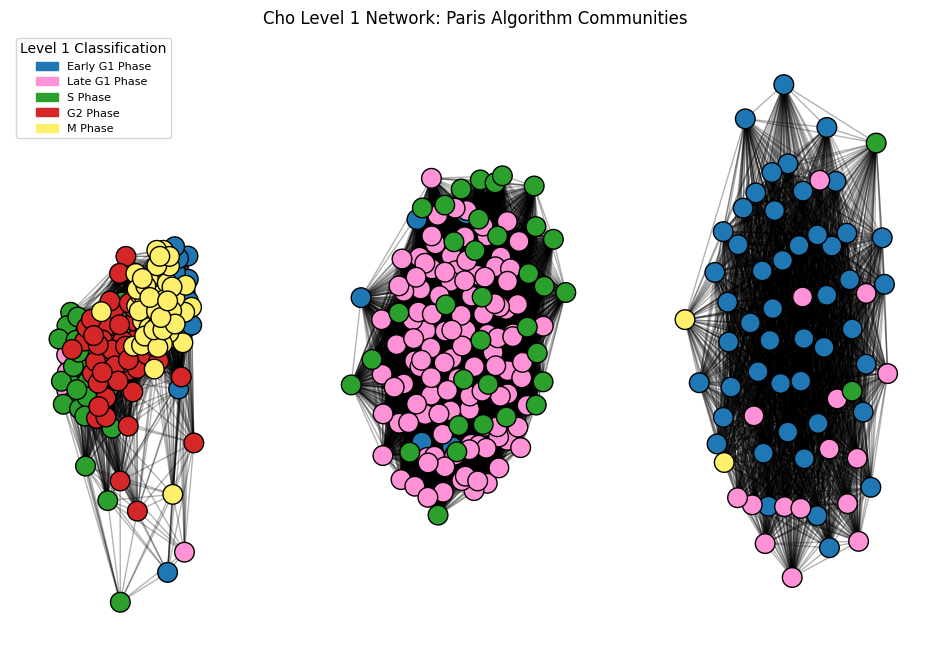

In [ ]:
visualize_disconnected_communities(G, paris_communities, color_map, title="Level 1 Network: Paris Algorithm Communities")

## LFM Algorithm

In [26]:
random.seed(42)
np.random.seed(42)
# test value of alpha = 0.9
alpha_values = np.arange(0.1, 1.0, 0.1)
lfm_results_list = []
lfm_communities = []
for alpha in alpha_values:
	lfm_alpha = alpha
	curr_community = algorithms.lfm(G, alpha=lfm_alpha)
	lfm_communities.append(curr_community)

	def evaluate_lfm():
		# Compute required metrics
		num_communities = len(curr_community.communities)
		largest_community_size = max(len(c) for c in curr_community.communities)
		community_sizes = [len(c) for c in curr_community.communities]
		num_singletons = sum(1 for c in curr_community.communities if len(c) == 1)
		modularity_score = evaluation.newman_girvan_modularity(G, curr_community).score
		closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

		node_counts = {}
		for i, community in enumerate(curr_community.communities):
			for node in community:
				if node not in node_counts:
					node_counts[node] = []
				node_counts[node].append(i)

		# Assign each node to the **smallest indexed** community it appears in
		predicted_labels_dict = {node: min(communities) for node, communities in node_counts.items()}

		# Create the final predicted labels list
		predicted_labels = [predicted_labels_dict[n] for n in G.nodes()]

		node_to_community = {node: idx for idx, community in enumerate(curr_community.communities) for node in community}
		true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]

		# ARI calculation
		ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)

		# RI calculation
		ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)

		# MRI calculation
		nodes_true_list = list(G.nodes())
		nodes_pred_list = list(node for community in curr_community.communities for node in community)
		mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)

		LFM_results = pd.DataFrame({
			"Alpha": [lfm_alpha],
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"RI (Level 1)": [ri_classifications_score1],
			"MRI (Level 1)": [mri_classifications_score1],
			"Communities": [curr_community.communities]
		})
		return LFM_results

	lfm_results_list.append(evaluate_lfm())

# Combine all results into a single DataFrame
LFM_results = pd.concat(lfm_results_list, ignore_index=True)
LFM_results


,Alpha,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,0.1,3,310,"[310, 4, 2]",0,0.003495,0.139642,0.010951,0.274302,0.274302,"[[YDL127w, YJR043c, YBR070c, YGR092w, YHR110w,..."
1,0.2,3,310,"[310, 4, 2]",0,0.003495,0.139642,0.010951,0.274302,0.274302,"[[YDL127w, YJR043c, YBR070c, YGR092w, YHR110w,..."
2,0.3,4,310,"[310, 60, 4, 2]",0,0.145624,0.139642,0.010951,0.274302,0.274302,"[[YDL127w, YJR043c, YBR070c, YGR092w, YHR110w,..."
3,0.4,4,310,"[310, 60, 4, 2]",0,0.145624,0.139642,0.010951,0.274302,0.274302,"[[YDL127w, YJR043c, YBR070c, YGR092w, YHR110w,..."
4,0.5,5,136,"[136, 121, 59, 4, 2]",0,0.380327,0.139642,0.466524,0.772895,0.772895,"[[YDL127w, YJL074c, YER070w, YDL010w, YLR382c,..."
5,0.6,8,136,"[136, 66, 56, 52, 7, 4, 3, 2]",0,0.388131,0.139642,0.555087,0.827386,0.827386,"[[YDL127w, YJL074c, YER070w, YDL010w, YLR382c,..."
6,0.7,9,135,"[135, 66, 54, 42, 14, 7, 4, 3, 2]",0,0.387929,0.139642,0.540484,0.824031,0.824031,"[[YDL127w, YJL074c, YER070w, YDL010w, YLR382c,..."
7,0.8,13,135,"[135, 66, 54, 42, 32, 26, 21, 7, 6, 4, 2, 2, 2]",0,0.366136,0.139642,0.540484,0.824031,0.824031,"[[YDL127w, YJL074c, YER070w, YDL010w, YLR382c,..."
8,0.9,23,132,"[132, 48, 38, 32, 22, 18, 17, 11, 9, 9, 7, 4, ...",0,0.362229,0.139642,0.539879,0.833896,0.833896,"[[YDL127w, YJL074c, YER070w, YDL010w, YLR382c,..."


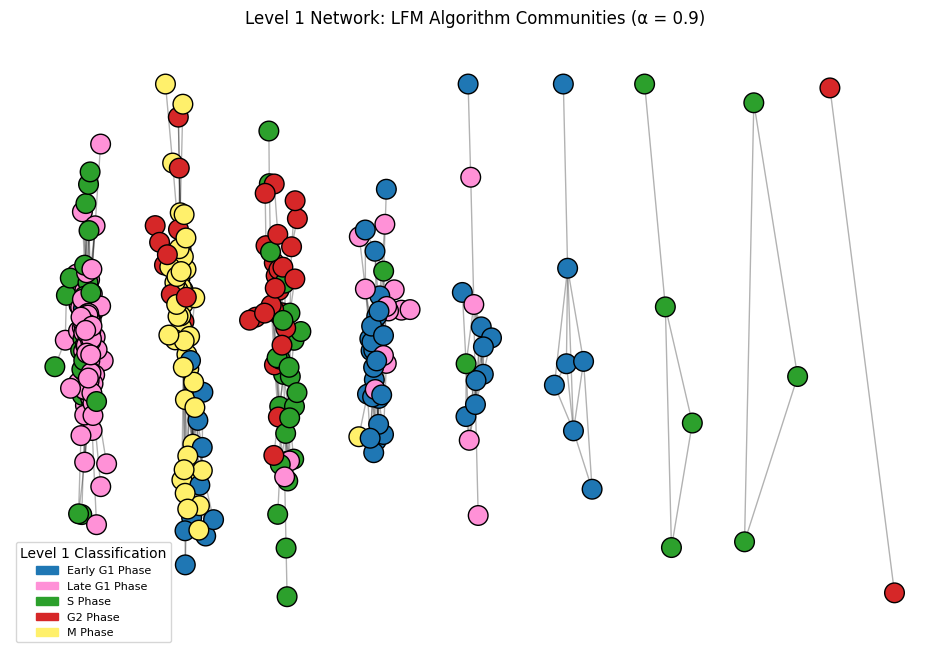

In [29]:
# Visualize the best performing LFM alpha value (alpha = 0.7)
best_lfm_communities = lfm_communities[6]
visualize_disconnected_communities(G, best_lfm_communities, color_map, title=f"Level 1 Network: LFM Algorithm Communities (α = {lfm_alpha})")

## Girvan Newman Algorithm

In [15]:
# level = 3 is best according to previous studies
gn_level = 3
gn_communities = algorithms.girvan_newman(G, level=gn_level)
def evaluate_gn():
	# Compute required metrics
	num_communities = len(gn_communities.communities)
	largest_community_size = max(len(c) for c in gn_communities.communities)
	community_sizes = [len(c) for c in gn_communities.communities]
	num_singletons = sum(1 for c in gn_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, gn_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(gn_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]

	node_to_community = {node: idx for idx, community in enumerate(gn_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	# true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	# ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	# ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in gn_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	# mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	GN_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			# "ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			# "RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			# "MRI (Level 2)": [mri_classifications_score2],
			"Communities": [gn_communities.communities]
	})
	return GN_results

GN_results = evaluate_gn()
# output_dir = "LFM - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# GN_results.to_csv(f"{output_dir}/GN_results_Cho.csv")
GN_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,4,381,"[381, 1, 1, 1]",3,0.000129,0.625778,0.003833,0.240399,0.240399,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


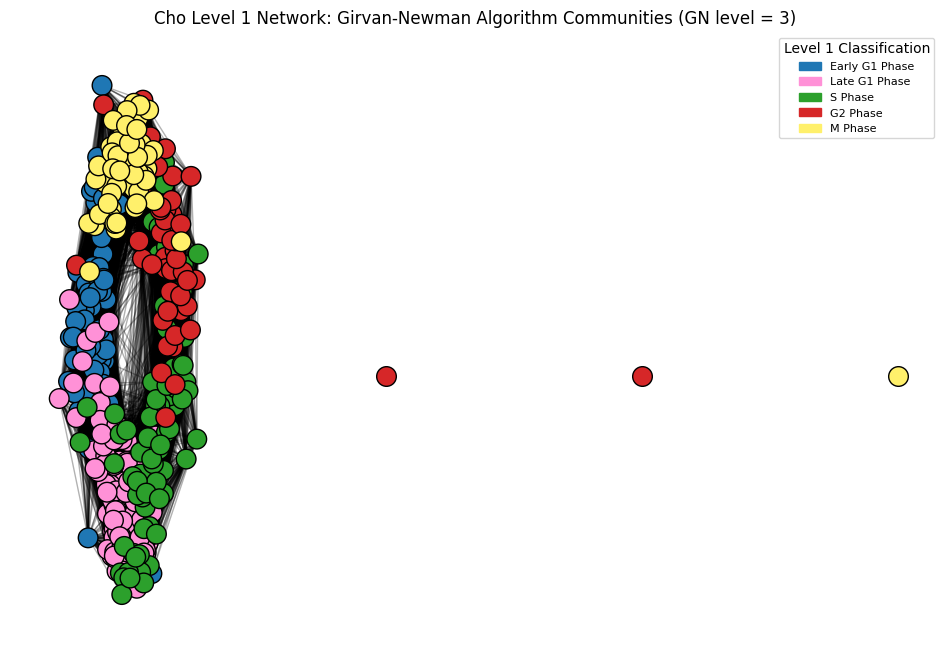

In [ ]:
visualize_disconnected_communities(G, gn_communities, color_map, title=f"Level 1 Network: Girvan-Newman Algorithm Communities (GN level = {gn_level})")

# Dynamic Community Detection
Using our formed network, we employ the Infomap and TILES algorithms.

## Infomap Algorithm

In [17]:
infomap_communities = algorithms.infomap(G)

def evaluate_infomap():
	# Compute required metrics
	num_communities = len(infomap_communities.communities)
	largest_community_size = max(len(c) for c in infomap_communities.communities)
	community_sizes = [len(c) for c in infomap_communities.communities]
	num_singletons = sum(1 for c in infomap_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, infomap_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(infomap_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]


	node_to_community = {node: idx for idx, community in enumerate(infomap_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	# true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	# ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	# ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in infomap_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	# mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Infomap_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			# "ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			# "RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			# "MRI (Level 2)": [mri_classifications_score2],
			"Communities": [infomap_communities.communities]
	})
	return Infomap_results

Infomap_results = evaluate_infomap()
# output_dir = "Infomap - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Infomap_results.to_csv(f"{output_dir}/Infomap_results_Cho.csv")
Infomap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,1,384,[384],0,5.107026e-15,0.625778,0.0,0.229031,0.229031,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


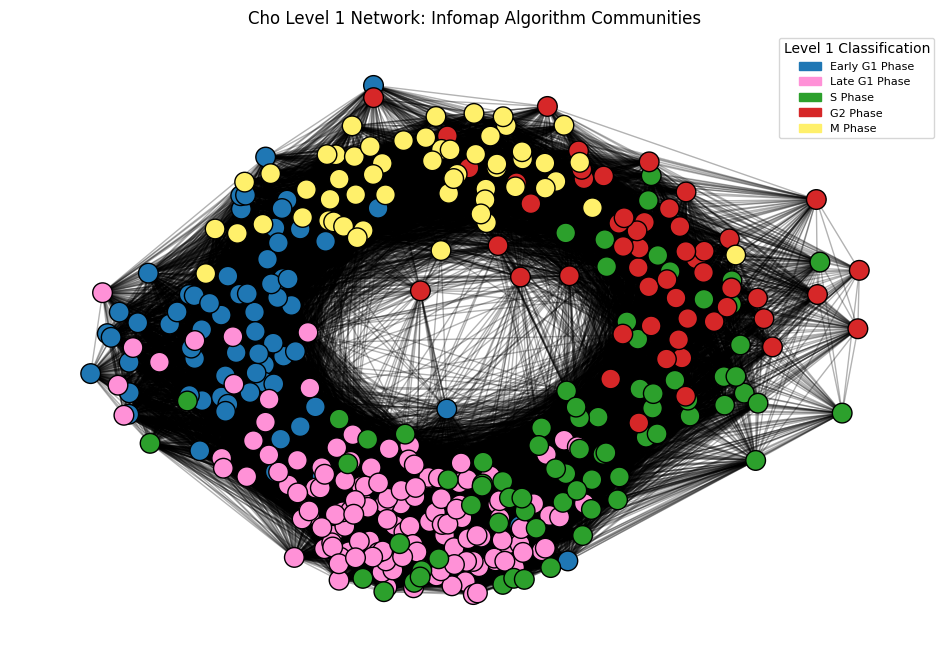

In [ ]:
visualize_disconnected_communities(G, infomap_communities, color_map, title="Level 1 Network: Infomap Algorithm Communities")

## Walktrap Algorithm

In [19]:
walktrap_communities = algorithms.walktrap(G)

def evaluate_walktrap():
	# Compute required metrics
	num_communities = len(walktrap_communities.communities)
	largest_community_size = max(len(c) for c in walktrap_communities.communities)
	community_sizes = [len(c) for c in walktrap_communities.communities]
	num_singletons = sum(1 for c in walktrap_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, walktrap_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(walktrap_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]


	node_to_community = {node: idx for idx, community in enumerate(walktrap_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	# true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	# ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	# ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in walktrap_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	# mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Walktrap_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			# "ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			# "RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			# "MRI (Level 2)": [mri_classifications_score2],
			"Communities": [walktrap_communities.communities]
	})
	return Walktrap_results

Walktrap_results = evaluate_walktrap()
# output_dir = "Walktrap - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Walktrap_results.to_csv(f"{output_dir}/Walktrap_results_Cho.csv")
Walktrap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,3,189,"[189, 136, 59]",0,0.352893,0.625778,0.396306,0.734239,0.734239,"[[2, 11, 29, 30, 32, 47, 61, 62, 63, 64, 67, 6..."


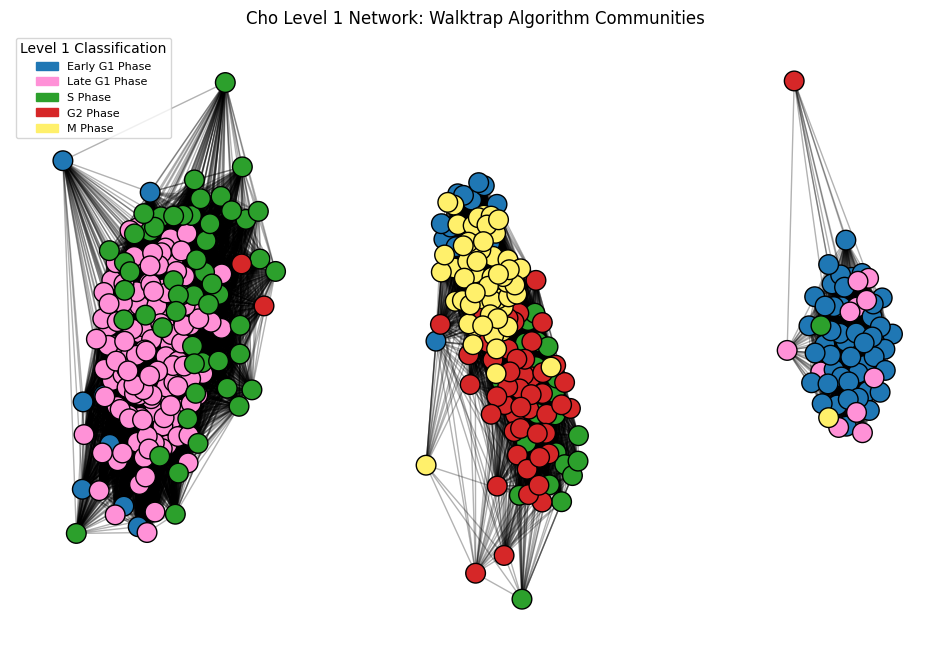

In [ ]:
visualize_disconnected_communities(G, walktrap_communities, color_map, title="Level 1 Network: Walktrap Algorithm Communities")

## Spinglass Algorithm

In [21]:
spinglass_communities = algorithms.spinglass(G)

def evaluate_spinglass():
	# Compute required metrics
	num_communities = len(spinglass_communities.communities)
	largest_community_size = max(len(c) for c in spinglass_communities.communities)
	community_sizes = [len(c) for c in spinglass_communities.communities]
	num_singletons = sum(1 for c in spinglass_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, spinglass_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(spinglass_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]


	node_to_community = {node: idx for idx, community in enumerate(spinglass_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	# true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	# ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	# ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in spinglass_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	# mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Spinglass_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			# "ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			# "RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			# "MRI (Level 2)": [mri_classifications_score2],
			"Communities": [spinglass_communities.communities]
	})
	return Spinglass_results

Spinglass_results = evaluate_spinglass()
# output_dir = "Spinglass - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Spinglass_results.to_csv(f"{output_dir}/Spinglass_results_Cho.csv")
Spinglass_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,3,171,"[171, 110, 103]",0,0.375367,0.625778,0.439328,0.765054,0.765054,"[[2, 11, 29, 30, 32, 63, 67, 68, 69, 70, 71, 7..."


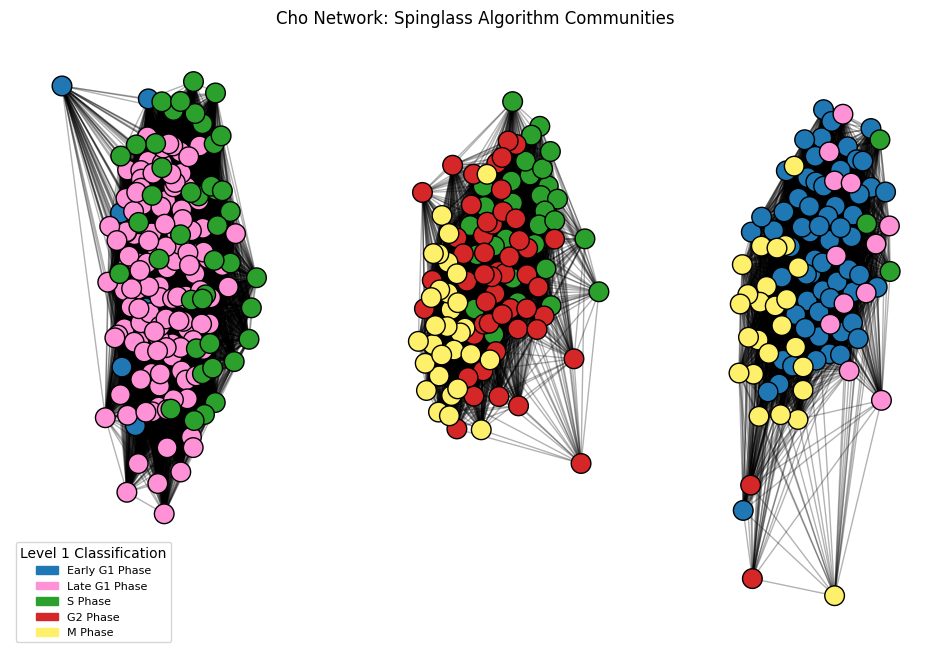

In [22]:
visualize_disconnected_communities(G, spinglass_communities, color_map, title="Cho Network: Spinglass Algorithm Communities")

## TILES Algorithm

In [23]:
print("TILES!")

TILES!


# Community Detection Results

In [24]:
Community_Detection_Results = pd.concat([Paris_results, LFM_results, GN_results, Infomap_results, Walktrap_results, Spinglass_results], axis=0)
Community_Detection_Results.index = ["Paris", "LFM", "Girvan-Newman", "Infomap", "Walktrap", "Spinglass"]

output_dir = "Community Detection Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
Community_Detection_Results.to_csv(f"{output_dir}/Cho_Level1Dataset_Communities.csv")

Community_Detection_Results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
Paris,3,162,"[162, 154, 68]",0,3.683312e-01,0.625778,0.362292,0.726583,0.726583,"[[280, 204, 209, 203, 247, 257, 282, 323, 223,..."
LFM,325,384,"[384, 216, 216, 216, 216, 216, 216, 216, 216, ...",0,3.489210e-01,0.625778,0.000000,0.229031,0.229031,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
Girvan-Newman,4,381,"[381, 1, 1, 1]",3,1.292762e-04,0.625778,0.003833,0.240399,0.240399,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
Infomap,1,384,[384],0,5.107026e-15,0.625778,0.000000,0.229031,0.229031,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
Walktrap,3,189,"[189, 136, 59]",0,3.528932e-01,0.625778,0.396306,0.734239,0.734239,"[[2, 11, 29, 30, 32, 47, 61, 62, 63, 64, 67, 6..."
Spinglass,3,171,"[171, 110, 103]",0,3.753671e-01,0.625778,0.439328,0.765054,0.765054,"[[2, 11, 29, 30, 32, 63, 67, 68, 69, 70, 71, 7..."


# Second Level Community Detection

Since Paris is the best performing, we apply the Paris algorithm on its detected community to get more granular classifications.

In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

def visualize_disconnected_communities_subcluster(G, communities, level_2_colors, title="Paris Algorithm Communities (Level 2)", figsize=(12, 8)):
    """
    Visualizes detected communities as separate disconnected subgraphs while keeping Level 2 colors.

    Parameters:
    - G: NetworkX graph
    - communities: CDLib NodeClustering object (Paris, Infomap, Louvain, etc.)
    - level_2_colors: Dictionary mapping Level 2 categories to colors
    - title: Title for the plot
    """
    
    # Mapping of Level 2 classification numbers to descriptive names
    level_2_mapping = {
        11: "Early G1: Cell Cycle Regulation",
        12: "Early G1: Directional Growth",
        13: "Early G1: DNA Replication",
        14: "Early G1: Mating Pathway",
        15: "Early G1: Glycolysis Respiration",
        16: "Early G1: Biosynthesis",
        17: "Early G1: Miscellaneous",

        21: "Late G1: Cell Cycle Regulation",
        22: "Late G1: Chromosome Segregation",
        23: "Late G1: Directional Growth",
        24: "Late G1: DNA Replication",
        25: "Late G1: Repair and Recombination",
        26: "Late G1: Transcription Factors",
        27: "Late G1: Mating Pathway",
        28: "Late G1: Glycolysis Respiration",
        29: "Late G1: Biosynthesis",

        31: "S Phase: Cell Cycle Regulation",
        32: "S Phase: Chromosome Segregation",
        33: "S Phase: Directional Growth",
        34: "S Phase: DNA Replication",
        35: "S Phase: Repair and Recombination",
        36: "S Phase: Transcription Factors",
        37: "S Phase: Glycolysis Respiration",
        38: "S Phase: Biosynthesis",
        39: "S Phase: Miscellaneous",

        41: "G2 Phase: Cell Cycle Regulation",
        42: "G2 Phase: Chromosome Segregation",
        43: "G2 Phase: Directional Growth",
        44: "G2 Phase: DNA Replication",
        45: "G2 Phase: Repair and Recombination",
        46: "G2 Phase: Transcription Factors",
        47: "G2 Phase: Glycolysis Respiration",
        48: "G2 Phase: Biosynthesis",
        49: "G2 Phase: Miscellaneous",

        51: "M Phase: Cell Cycle Regulation",
        52: "M Phase: Chromosome Segregation",
        53: "M Phase: Directional Growth",
        54: "M Phase: DNA Replication",
        55: "M Phase: Repair and Recombination",
        56: "M Phase: Transcription Factors",
        57: "M Phase: Mating Pathway",
        58: "M Phase: Glycolysis Respiration",
        59: "M Phase: Biosynthesis",
    }

    # Define layout positioning for separate communities
    num_communities = len(communities.communities)
    fig, ax = plt.subplots(figsize=figsize)

    # Adjust community spacing
    spacing = 3
    pos_dict = {}  # Dictionary to store layout positions for each community

    # Track Level 2 categories that appear in the graph
    present_level_2_classes = set()

    # Compute separate layouts for each community
    for i, community in enumerate(communities.communities):
        subG = G.subgraph(community).copy()
        
        # Ensure the subgraph is non-empty
        if len(subG.nodes) > 0:
            pos = nx.spring_layout(subG, seed=42, k=0.5)  # More separation with k

            # Shift positions to separate communities
            for node in pos:
                pos[node] += [i * spacing, 0]

            pos_dict[i] = pos  # Store position layout

    # Draw each community separately
    for i, community in enumerate(communities.communities):
        subG = G.subgraph(community).copy()

        if len(subG.nodes) > 0:
            pos = pos_dict[i]  # Get the computed layout
            
            # Assign Level 2 colors
            node_colors = []
            for n in subG.nodes():
                lvl2 = G.nodes[n]["level_2"]
                node_colors.append(level_2_colors[lvl2])
                present_level_2_classes.add(lvl2)  # Track only appearing classes

            # Draw nodes
            nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

            # Draw edges
            nx.draw_networkx_edges(subG, pos, alpha=0.3, edge_color="black")

    # Create a legend only for Level 2 classifications that appear in the graph
    legend_handles_lvl2 = [Patch(color=level_2_colors[cls], label=level_2_mapping[cls]) 
                           for cls in present_level_2_classes]
    
    # Add the filtered legend
    plt.legend(handles=legend_handles_lvl2, loc="best", fontsize=8, title="Level 2 Classification")

    # Display
    plt.title(title)
    plt.axis("off")
    plt.show()


In [26]:
def evaluate_paris_subclusters():
	second_level_paris_results = []
	# Apply Paris algorithm on each community detected in the first run
	for idx, community in enumerate(paris_communities.communities):
			# Extract the subgraph corresponding to this community
			subgraph = G.subgraph(community).copy()
			
			# Ensure the subgraph is non-empty
			if len(subgraph.nodes) > 1:
					# Apply Paris again on this subgraph
					sub_paris_communities = algorithms.paris(subgraph)

					# Compute required metrics
					num_sub_communities = len(sub_paris_communities.communities)
					largest_sub_community_size = max(len(c) for c in sub_paris_communities.communities)
					sub_community_sizes = [len(c) for c in sub_paris_communities.communities]
					num_sub_singletons = sum(1 for c in sub_paris_communities.communities if len(c) == 1)
					modularity_score = evaluation.newman_girvan_modularity(subgraph, sub_paris_communities).score
					closeness_centrality = np.mean(list(nx.closeness_centrality(subgraph).values()))

					# Assign labels for comparison
					predicted_labels_dict = {node: -1 for node in subgraph.nodes()}
					for i, community in enumerate(sub_paris_communities.communities):
							for node in community:
									predicted_labels_dict[node] = i
					predicted_labels = [predicted_labels_dict[node] for node in subgraph.nodes()]

					# True labels from original graph
					true_labels_level_1 = [G.nodes[n]["level_1"] for n in subgraph.nodes()]
					# true_labels_level_2 = [G.nodes[n]["level_2"] for n in subgraph.nodes()]

					# ARI calculation
					ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
					# ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

					# RI calculation
					ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
					# ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

					# Store results
					second_level_paris_results.append({
							"Community Index": idx,
							"Number of Sub-Communities": num_sub_communities,
							"Nodes in Largest Sub-Community": largest_sub_community_size,
							"Sub-Community Sizes": sub_community_sizes,
							"Singletons": num_sub_singletons,
							"Modularity": modularity_score,
							"ARI (Level 1)": ari_classifications_score1,
							# "ARI (Level 2)": ari_classifications_score2,
							"RI (Level 1)": ri_classifications_score1,
							# "RI (Level 2)": ri_classifications_score2,
							"Communities": sub_paris_communities.communities
					})
	return second_level_paris_results

second_level_paris_results = evaluate_paris_subclusters()
# Convert to DataFrame for analysis
Second_Level_Paris_df = pd.DataFrame(second_level_paris_results)
Second_Level_Paris_df

NetworkXUnfeasible: The node label sets are overlapping and no ordering can resolve the mapping. Use copy=True.

In [27]:
def visualize_paris_community_subclusters():
	for idx, community in enumerate(paris_communities.communities):
			subgraph = G.subgraph(community).copy()
			
			if len(subgraph.nodes) > 1 and len(subgraph.edges) > 0:
					sub_paris_communities = algorithms.paris(subgraph)

					if idx == 0:
							visualize_disconnected_communities_subcluster(subgraph, sub_paris_communities, level_2_colors, 
																															title=f"Paris Subgraph {idx+1} - Hierarchical Communities (Level 2)",
																															figsize=(12, 8))
					else: 
						visualize_disconnected_communities_subcluster(subgraph, sub_paris_communities, level_2_colors, 
																													title=f"Paris Subgraph {idx+1} - Hierarchical Communities (Level 2)")
visualize_paris_community_subclusters()

NameError: name 'level_2_colors' is not defined